In [21]:
from __future__ import division
from nltk.corpus import stopwords
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.probability import FreqDist
from collections import Counter
import copy
from math import log
from sklearn.datasets import fetch_20newsgroups
import pickle
import re

ddd = None

from nltk.tokenize import word_tokenize

def get_BigramCollocationFinder(inputs):
  wordfdist = FreqDist()
  bigramfdist = FreqDist()

  for i in inputs:
    finder = BigramCollocationFinder.from_words(i,window_size=5)
    for key,val in finder.ngram_fd.items():
      bigramfdist[key] += val
    for key,val in finder.word_fd.items():
      wordfdist[key] += val

  return BigramCollocationFinder(wordfdist,bigramfdist)

class PrepareVocab:
    def __init__(self, filteredBigramPMIs, wordsPMITable, vocabList, word2count, docs, word2docID):
        self.vocab = vocabList
        self.filteredBigramPMIs = filteredBigramPMIs
        self.wordsPMITable =  wordsPMITable
        self.word2docID = word2docID
        self.docs = docs
        
 
    def returnVocabDist(self, docs, topN):
        allWords = []
        for doc in docs:
            allWords.extend(doc.split(" "))
        fdist = FreqDist(allWords)
        
        common = fdist.most_common(topN)
        common = [item[0] for item in common]
        ddd =common
        return common
    
    
    def _returnWord2Index (self):
        word2index = {}
        vocab = list(self.vocab)
        for i in range(len(self.vocab)):
            word2index[vocab[i]] = i
        return word2index
    
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()

class PrepareNPMITable:
    def __init__(self, docs):
        #vocab = self.returnVocabDist(docs)
        self.StopWords = self.readWordsList("stopwords_topicm1.txt")
        self.docs = self.preprocessing(docs)
        
        
        
    def readWordsList(self, dicFile):
        negatorList = set(line.strip() for line in open(dicFile))
        return negatorList
    
    """def returnVocabDist(self, docs):
        allWords = []
        for doc in docs:
            allWords.extend(doc.split(" "))
        fdist = FreqDist(allWords)
        common = fdist.most_common()
        print(len(common))
        return"""
    
    def preprocessing(self, docs):
        stopWords = set(stopwords.words('english')).union(self.StopWords)

  
        normalizedDocs = []

        for s in docs:
            ori_s = s
            s = re.sub("\n","",s).lower()
            s = s.split(" ")
            s_pos_tag = pos_tag(s)
            s = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemmatizer.lemmatize(i) for i,j in s_pos_tag]
            filteredWords = []
            for w,tag in zip(s,s_pos_tag):
                alphabet = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
                if alphabet is None or len(w)<1 or w in stopWords:
                    continue
                elif tag[1][0].lower() in ['v']:
                    continue
                else:
                    filteredWords.append(w.lower())
            normalizedDocs.append(" ".join(filteredWords))


        return normalizedDocs
        
        
    def limitDocsToVocab(self, docs, vocab):
        reducedDocs = []
        for s in docs:
            doc = []
            s = s.split(" ")[0]
            for w in s:
                if w in vocab:
                    doc.append(w)
            reducedDocs.append(" ".join(doc))
        return reducedDocs
    
    
    def npmi_scorer(self, worda_count, wordb_count, bigram_count, min_count, corpus_word_count):
        if bigram_count >= min_count:
            pa = worda_count / corpus_word_count
            pb = wordb_count / corpus_word_count
            pab = bigram_count / corpus_word_count
            return log(pab / (pa * pb)) / -log(pab)
        else:
            # Return -infinity to make sure that no phrases will be created
            # from bigrams less frequent than min_count
            return float('-inf')
               
    
    
    def returnWord2DocID(self):#THis function returns a dictionary where each key is a word from vocab and each value is a list of DocIDs that word is present in.
        word2doc_id = {}
        tokenizedDocs = [doc.split(" ") for doc in self.docs]
        all_tokens = [item for sublist in tokenizedDocs for item in sublist]
        vocab = list(set(all_tokens))
        
        for w in vocab:
            if w not in word2doc_id:
                word2doc_id[w] = []
            for i in range(len(self.docs)):
                if w in self.docs[i]:
                    word2doc_id[w].append(i)
        print("if chip is here")
        print("chip" in word2doc_id)
        return word2doc_id
        
        
    
    def returnPMIScores(self, vocabSize = 5000, readFromDisk = False):
        
        if not readFromDisk:
        
            tokenizedDocs = [doc.split(" ") for doc in self.docs]
            
            all_tokens = [item for sublist in tokenizedDocs for item in sublist]
            token2count = Counter(all_tokens)
            totalTokenCount = sum(token2count.values())
            #print totalTokenCount
            
            #finder = BigramCollocationFinder.from_documents(tokenizedDocs)

            finder =get_BigramCollocationFinder(tokenizedDocs)
            finder.apply_freq_filter(2)
            bigram_measures = nltk.collocations.BigramAssocMeasures()
            bigramPMIs =  (finder.score_ngrams(bigram_measures.pmi))

            unsuccessfulNPMICases = 0
            NPMIs = []
            for item in bigramPMIs:
                if item[1]>0:
                    try:
                      NPMIs.append((item[0], self.npmi_scorer(float(token2count[item[0][0]]), float(token2count[item[0][1]]), float(finder.ngram_fd[(item[0][0], item[0][1])]), 0.0, float(totalTokenCount))))
                    except:
                      unsuccessfulNPMICases+=1
 
            sortedVocab = sorted(token2count, key=token2count.get, reverse = True)
            vocab = sortedVocab[:vocabSize]
            
            """Pickle and save outputs"""
            
            output_NPMIs = open('NPMIs.pkl', 'wb')
            pickle.dump(NPMIs, output_NPMIs,protocol=pickle.HIGHEST_PROTOCOL)
            
            output_token2count = open('token2count.pkl', 'wb')
            pickle.dump(token2count, output_token2count,protocol=pickle.HIGHEST_PROTOCOL)
            
            
            output_vocab = open('vocab.pkl', 'wb')
            pickle.dump(vocab, output_vocab,protocol=pickle.HIGHEST_PROTOCOL)
        else:
            NPMIs =  pickle.load(open('NPMIs.pkl', 'rb'))
            token2count = pickle.load(open('token2count.pkl', 'rb'))
            vocab = pickle.load(open('vocab.pkl', 'rb'))
        return NPMIs, token2count, vocab#bigramPMIs


    def costructWordGraphs(self, bigramPMIs):
        words = []
        for i in range(len(bigramPMIs)):
            words.append(bigramPMIs[i][0][0])
            words.append(bigramPMIs[i][0][1])
        
        cnt = Counter(words)
        return cnt
    
      

    def createWordPairPMITable(self, vocab, PMIstorage, cnt_words, readFromDisk = False):
        if not readFromDisk:
            table = {}
            temp = {}
            for w in vocab:
                table[w] = 0
                temp[w] = 0
                
                
            for w in vocab:
                table[w] = copy.deepcopy(temp)
            
            for item in PMIstorage:
                if cnt_words[item [0][0]] == 1 and cnt_words[item [0][1]] == 1:
                    pass
                else:
                    table[item[0][0]][item[0][1]] = item[1]
                    table[item[0][1]][item[0][0]] = item [1]
                    
            output_table = open('table.pkl', 'wb')
            pickle.dump(table, output_table,protocol=pickle.HIGHEST_PROTOCOL)
        else:

            table =  pickle.load(open('table.pkl', 'rb'))
        return table

def readNewsGroupsDataset (cats = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x','misc.forsale','rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey','sci.crypt','sci.electronics','sci.med','sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast','talk.politics.misc', 'talk.religion.misc']):
            
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)
    trainData = newsgroups_train.data
    trainLabels =  newsgroups_train.target
        
    newsgroups_test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'), categories=cats)
    testData = newsgroups_test.data
    testLabels = newsgroups_test.target
    
    trainData = [str(doc.encode('utf-8').lower()) for doc in trainData]
    testData = [str(doc.encode('utf-8').lower()) for doc in testData]

    return trainData, trainLabels, testData, testLabels
    



def returnNPMIEmbeddingOfWordsList (wordsList, wordsPMITable):
    NPMI_Embeddings = []
    for i in range(len(wordsList)):
        try:
            NPMI_Embeddings.append(returnWordPairPMI(wordsList[i],[x for ind,x in enumerate(wordsList) if ind!=i], wordsPMITable))  
        except:
            pass
    return NPMI_Embeddings

def returnWordPairPMI(word,cellWordsList, wordsPMITable):
    PMIs = []
    for w in cellWordsList:
        PMIs.append(wordsPMITable [word][w])
        
    return sum(PMIs)/len(PMIs)

def returnWord2NumOfDocuments (documents):
    word_frequencies = [Counter(document.split()) for document in documents]

    #calculate document frequency
    document_frequencies = Counter()
    map(document_frequencies.update, (word_frequency.keys() for word_frequency in word_frequencies))

    return document_frequencies    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
#read file new version
import json
import os

summary = []

with open('train_0_summary_input.json') as f:
   data = json.load(f)
summary = data


In [29]:
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
docs = summary
print(len(summary))
npm = PrepareNPMITable(docs)

print("returnPMIScores")
bigramPMIs, word2count, vocab = npm.returnPMIScores(vocabSize = 2000, readFromDisk = False)
print(len(vocab))

filteredBigramPMIs = []
for item in bigramPMIs:
    if item[1]>0:
        filteredBigramPMIs.append(item)

filteredBigramPMIs = sorted(filteredBigramPMIs, key=lambda x: x[1])

cnt_words = npm.costructWordGraphs(bigramPMIs)


print("creating PMI Table")
wordsPMITable = npm.createWordPairPMITable(cnt_words.keys(), filteredBigramPMIs, cnt_words, readFromDisk = False)


doc = "encryption secure system space"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


292
returnPMIScores
256
creating PMI Table


In [30]:
word2docID = npm.returnWord2DocID()
#docs = ntm.limitDocsToVocab(ntm.docs,cnt_words.keys())
print('Initializing with prepVocab')

prepVocab = PrepareVocab(filteredBigramPMIs, wordsPMITable, cnt_words.keys(), cnt_words, npm.docs, word2docID)
#prepVocab = PrepareVocab(filteredBigramPMIs, wordsPMITable, vocab, cnt_words, npm.docs, word2docID)

word2NumOfDocs = returnWord2NumOfDocuments(npm.docs)

word2index = prepVocab._returnWord2Index()
vocab = list(word2index.keys())

"""The following lines produce npmi embeddings for the entire vocabulary (Equation 6)"""
vocab_npmiEmbedds = returnNPMIEmbeddingOfWordsList(vocab, wordsPMITable)
print(len(vocab_npmiEmbedds))

wordsNPMIs = []
for i in range(len(vocab)):
    wordsNPMIs.append((vocab[i], vocab_npmiEmbedds[i]))
wordsNPMIs = sorted(wordsNPMIs, key=lambda x: x[1], reverse=True)
print(len(wordsNPMIs))
print(wordsNPMIs)  

if chip is here
True
Initializing with prepVocab
94
94
[('remote', 0.11165468909115067), ('button', 0.07898627435236968), ('group', 0.057098172193078), ('battery', 0.042039885523804346), ('initial', 0.034118745359437215), ('rubber', 0.03410739910520908), ('channel', 0.032299290359268026), ('cost', 0.030817126756846367), ('corporate', 0.030782703251735252), ('volume', 0.030327812487431407), ('production', 0.030202853242218376), ('final', 0.028722030756290214), ('changeable', 0.028414601548298255), ('plastic', 0.024822706540914473), ('company', 0.024389930855130568), ('color', 0.024249457074681045), ('display', 0.022721466135419647), ('fruit', 0.02168165212450169), ('rechargeable', 0.021067492125551802), ('menu', 0.020859940701658912), ('product', 0.01991154955948313), ('recharging', 0.019787763430568473), ('power', 0.019691920585656865), ('function', 0.019361734155530747), ('logo', 0.019052188098015625), ('yellow', 0.01805291347956973), ('image', 0.01761371450405586), ('recognizable', 0

In [31]:
seed = [i[0] for i in wordsNPMIs[1:] if i!='remote']
word_vec = []

for word1 in seed:
  tmp = []
  for word2 in seed:
    if word1==word2:
      tmp.append(1)
    else:
      tmp.append(wordsPMITable[word1][word2])
  word_vec.append(tmp)

In [32]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array(word_vec)
kmeans = KMeans(n_clusters=35).fit(X)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

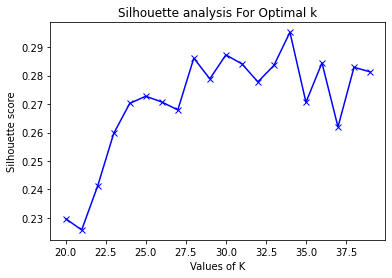

In [33]:
#https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Sum_of_squared_distances = []
X = np.array(word_vec)
K = range(20,40)

silhouette_avg = []
for num_clusters in K:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(X, cluster_labels))
 
plt.plot(K,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [34]:
from collections import defaultdict
cluster_to_word = defaultdict(list)

for i in range(len(seed)):
  cluster_to_word[labels[i]].append(seed[i])

print(cluster_to_word)

defaultdict(<class 'list'>, {21: ['button'], 27: ['group'], 5: ['battery', 'rechargeable', 'recharging'], 4: ['initial', 'goal'], 34: ['rubber', 'kinetic'], 6: ['channel', 'volume', 'menu', 'power'], 32: ['cost', 'production', 'final'], 2: ['corporate', 'image', 'recognizable'], 3: ['changeable', 'cover'], 23: ['plastic', 'hard'], 11: ['company', 'logo', 'cutout'], 30: ['color', 'design'], 13: ['display', 'expert', 'marketing'], 25: ['fruit', 'vegetable'], 24: ['product', 'sporting'], 19: ['function', 'scroll'], 10: ['yellow', 'organic', 'shape'], 31: ['euro', 'control'], 7: ['case', 'single'], 8: ['price', 'selling', 'twenty'], 14: ['profit', 'fifty', 'aim'], 12: ['project', 'manager'], 18: ['simple', 'advanced', 'voice'], 9: ['recognition', 'speech'], 15: ['lcd', 'screen', 'touch'], 17: ['light', 'gray'], 28: ['device', 'locator'], 16: ['wheel', 'push'], 22: ['center', 'swapping', 'symbol', 'mute'], 20: ['feature', 'prototype', 'target'], 0: ['television', 'team'], 26: ['order', 'lit

In [ ]:
seed_cluster = {}
import json
for i in range(len(seed)):
  seed_cluster[seed[i]]=str(labels[i])

In [ ]:
f = open("word_0.json","w")
json.dump(seed_cluster, f)